In [3]:
import pandas as pd
import numpy as np
import rioxarray
import rasterio

import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [4]:
uganda_data = pd.read_csv("Uganda Malaria Data/mock_malaria_cases_uganda_2km_2018.csv")

In [5]:
Z = uganda_data["malaria"].to_numpy().reshape(-1, 1)

In [6]:
x = uganda_data["x"].to_numpy()

In [7]:
y = uganda_data["y"].to_numpy()

In [8]:
lst = uganda_data["lst"].to_numpy()

In [9]:
rain = uganda_data["rainfall"].to_numpy()

In [10]:
elevation = uganda_data["elevation"].to_numpy()

In [11]:
X = np.stack((x, y, lst, rain, elevation), axis = -1)

In [12]:
rbf = gpflow.kernels.RBF(active_dims = [0, 1], lengthscales=1.0)
linear = gpflow.kernels.Linear(active_dims = [2, 3, 4])
kernel = rbf + linear

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)

In [14]:
model = gpflow.models.GPR(data = (X_train, Y_train), kernel = kernel)

In [15]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -15.133285767227562
        x: [ 2.774e+00 -3.693e+00 -5.698e+00 -6.197e+00]
      nit: 19
      jac: [-5.759e-07  2.693e-06  8.854e-07  1.735e-06]
     nfev: 30
     njev: 30
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [16]:
malaria_prevalence = rioxarray.open_rasterio("Uganda Malaria Data/mock_malaria_prevelance_uganda_2km_2018.tif").squeeze()

In [17]:
left, bottom, right, top = malaria_prevalence.rio.bounds()

In [18]:
x = np.linspace(left, right, 285)
y = np.linspace(bottom, top, 285)
x1, x2 = np.meshgrid(x, y)
X_grid = np.stack((x1.ravel(), x2.ravel()), axis = -1)

In [22]:
with rasterio.open("Uganda Standardized Rasters/standard_uganda_LSTday_2km_2018.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
lst_data = np.array(values)

In [23]:
with rasterio.open("Uganda Standardized Rasters/standard_uganda_Rainfall_CHIRPS_2km_2018.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
rain_data = np.array(values)

In [24]:
with rasterio.open("Uganda Standardized Rasters/standard_uganda_elevation_2km.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
elevation_data = np.array(values)

In [93]:
X_grid = np.concatenate((X_grid, lst_data[:, np.newaxis], rain_data[:, np.newaxis], elevation_data[:, np.newaxis]), axis = -1)

In [94]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [95]:
# Make predictions on the grid
Z_fmean_grid, Z_fvar_grid = model.predict_f(X_grid)

# Reshape the grid predictions to match the grid shape
Z_fmean_grid = Z_fmean_grid.reshape(x1.shape)
Z_fvar_grid = Z_fvar_grid.reshape(x1.shape)

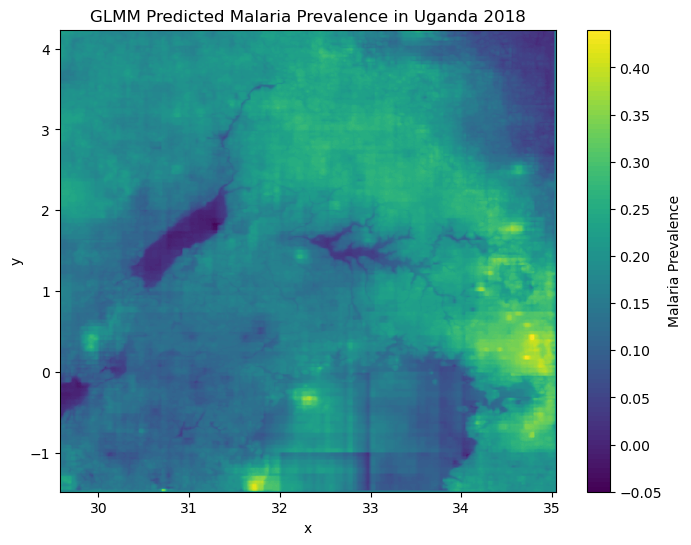

In [96]:
plt.figure(figsize=(8, 6))
plt.contourf(x, y, Z_fmean_grid, levels=100, cmap='viridis')
plt.colorbar(label='Malaria Prevalence')

plt.xlabel('x')
plt.ylabel('y')
plt.title('GLMM Predicted Malaria Prevalence in Uganda 2018')
plt.savefig("Uganda Malaria Data/mock_malaria_cases_uganda_randomfield_2km_2018.png") 
plt.show()